In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
ecalls = pd.read_csv('../data/911_Phone_Calls_Tornado.csv')
print(ecalls.shape)
ecalls.head(3)

(475, 5)


,Seizure DateTime,CallTypeId,ALI Latitude,ALI Longitude,Cell Tower Address
0,3/3/2020 0:34,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector
1,3/3/2020 0:36,911 Calls,36.159634,-86.841904,4507D KENTUCKY AV - SE
2,3/3/2020 0:36,911 Calls,36.264153,-86.708862,329 THELMA ST - S Sector


In [3]:
ecalls.columns = ['time', 'calltype', 'lat', 'lng', 'cell_tower_address']
ecalls = ecalls.dropna(subset = ['lat', 'lng'])

In [4]:
type(ecalls)

pandas.core.frame.DataFrame

In [5]:
ecalls['geometry'] = ecalls.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
ecalls.head(3)

,time,calltype,lat,lng,cell_tower_address,geometry
0,3/3/2020 0:34,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector,POINT (-86.665779 36.072708)
1,3/3/2020 0:36,911 Calls,36.159634,-86.841904,4507D KENTUCKY AV - SE,POINT (-86.841904 36.159634)
2,3/3/2020 0:36,911 Calls,36.264153,-86.708862,329 THELMA ST - S Sector,POINT (-86.708862 36.264153)


In [6]:
type(ecalls)

pandas.core.frame.DataFrame

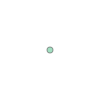

In [7]:
ecalls.loc[0, 'geometry']

In [8]:
print(ecalls.loc[0, 'geometry'])

POINT (-86.665779 36.072708)


In [9]:
ecalls.plot

In [10]:
paths = gpd.read_file('../data/path_polygons.geojson')
print(paths.crs)
paths.head( )

epsg:4326


,efscale,geometry
0,EF3,"POLYGON ((-85.59922 36.17660, -85.59840 36.176..."
1,EF1,"POLYGON ((-85.52390 36.17189, -85.52430 36.171..."
2,EF1,"POLYGON ((-85.61527 36.17529, -85.61403 36.175..."
3,EF3,"POLYGON ((-85.55185 36.17398, -85.55184 36.173..."
4,EF0,"POLYGON ((-86.94788 36.17248, -86.94582 36.172..."


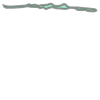

In [11]:
paths.loc[0, 'geometry']

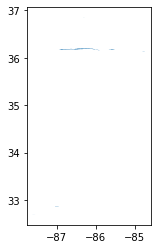

In [12]:
paths.plot();

In [13]:
paths.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
paths_geo = gpd.GeoDataFrame(ecalls, 
                           crs = paths.crs, 
                           geometry = ecalls['geometry'])

In [15]:
ecalls = ecalls[['time', 'geometry']]

In [16]:
calls_by_location = gpd.sjoin(paths_geo, paths, op = 'within')

In [17]:
calls_by_location.head()

,time,calltype,lat,lng,cell_tower_address,geometry,index_right,efscale
6,3/3/2020 0:37,911 Calls,36.175811,-86.895654,WIRELESS CALLER,POINT (-86.89565 36.17581),4,EF0
7,3/3/2020 0:37,911 Calls,36.180500,-86.883681,WIRELESS CALLER,POINT (-86.88368 36.18050),4,EF0
11,3/3/2020 0:39,911 Calls,36.173183,-86.797335,907 12TH AV N - N,POINT (-86.79734 36.17318),4,EF0
19,3/3/2020 0:41,911 Calls,36.175361,-86.782658,500 5TH AV - SECTOR NE N,POINT (-86.78266 36.17536),4,EF0
21,3/3/2020 0:41,911 Calls,36.170395,-86.801689,1409 E E JEFFERSON ST - N Sector,POINT (-86.80169 36.17039),4,EF0


In [18]:
calls_by_location['time'].value_counts()

3/3/2020 0:58    15
3/3/2020 0:43    14
3/3/2020 1:35    13
3/3/2020 1:59    11
3/3/2020 0:59    11
                 ..
3/3/2020 2:10     1
3/3/2020 2:22     1
3/3/2020 0:39     1
3/3/2020 1:30     1
3/3/2020 2:00     1
Name: time, Length: 95, dtype: int64

In [19]:
ecalls_nashville = calls_by_location.loc[calls_by_location['calltype'] == '911 Calls']
ecalls_nashville.shape

(325, 8)

In [20]:
polygon_nashville = paths.loc[paths['efscale'] == 'EF3']
polygon_nashville.shape

(7, 2)

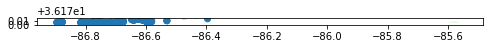

In [21]:
ax = polygon_nashville.plot(figsize = (8, 10), color = 'lightgreen')
ecalls_nashville.plot( ax = ax, column = 'calltype');
plt.show();

In [22]:
center = polygon_nashville.geometry.centroid[17]
print(center)

POINT (-86.47367783347669 36.18450237085148)


C:\Users\andyr\AppData\Local\Temp/ipykernel_38684/2826929434.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon_nashville.geometry.centroid[17]


In [23]:
nashville_center = [center.y, center.x]
print(nashville_center)

[36.184502370851476, -86.47367783347669]


In [24]:
map_nashville = folium.Map(location = nashville_center, zoom_start = 12)
map_nashville

In [25]:
i = 0
for row_index, row_values in ecalls_nashville.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 6
values are:
 
time                                         3/3/2020 0:37
calltype                                         911 Calls
lat                                              36.175811
lng                                             -86.895654
cell_tower_address                         WIRELESS CALLER
geometry              POINT (-86.89565399999999 36.175811)
index_right                                              4
efscale                                                EF0
Name: 6, dtype: object
------------------------- 
index is 7
values are:
 
time                               3/3/2020 0:37
calltype                               911 Calls
lat                                      36.1805
lng                                   -86.883681
cell_tower_address               WIRELESS CALLER
geometry              POINT (-86.883681 36.1805)
index_right                                    4
efscale                                      EF0
Name: 7, dtype: object
-------------

In [26]:
map_nashville = folium.Map(location = nashville_center, zoom_start = 34)

folium.GeoJson(polygon_nashville).add_to(map_nashville)
for row_index, row_values in ecalls_nashville.iterrows():
    loc = [row_values['geometry'].centroid.y, row_values['geometry'].centroid.x]
    pop = str(row_values['calltype'])
    icon=folium.Icon(color="blue",icon="f1bb", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_nashville)
map_nashville.save('../maps/map_nashville.html')

map_nashville

In [27]:
folium.Map?

In [28]:
cluster_map_nashville = folium.Map(location =  nashville_center, zoom_start = 34)

marker_cluster = MarkerCluster().add_to(cluster_map_nashville)

folium.GeoJson(polygon_nashville).add_to(cluster_map_nashville)

for row_index, row_values in ecalls_nashville.iterrows():
    loc = [row_values['geometry'].centroid.y, row_values['geometry'].centroid.x]
    pop = str(row_values['calltype'])
    icon=folium.Icon(color="green",icon="f1bb", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

cluster_map_nashville.save('../maps/clusternashville.html')

cluster_map_nashville